In [10]:
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

2023-10-09 21:11:51.227421: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 21:11:51.894970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data

In [11]:
# hardcoded stuff
df_path = "data/otu_table_example.csv"

The original dataset has taxa counts as rows and samples as columns. Since the goal here is to predict taxa counts in the same sample I transpose the original data such that one row represents taxa counts from the same sample. 

In [12]:
df = pd.read_csv(df_path, index_col="Unnamed: 0").T

In [13]:
print(df)

              1050608  130468   3589405  355102   1081058  189592   354275   \
E000823.1.8         0        0        0        0        0        0        0   
E000823.2.6         0        0        0        0        0        0        0   
E000823.4.0         0        0        0        0        0        0        0   
E000823.5.0         0        0        0        0        0        0        0   
E000823.5.7         0        0        0        0        0        0        0   
...               ...      ...      ...      ...      ...      ...      ...   
E014086.30.4        0        0        0        0        0        1       11   
E014086.32.4        0        0        0        0        0        0       13   
E014086.33.5        0        0        0        0        0        0        0   
E014086.34.4        0        0        0        0        0        1        0   
E014086.36.0        0        0        0        0        0        0        0   

              4327628  326749   183857   ...  31792

The dataset contains 521 samples of 7244 taxa, most of which are very sparsely populated 

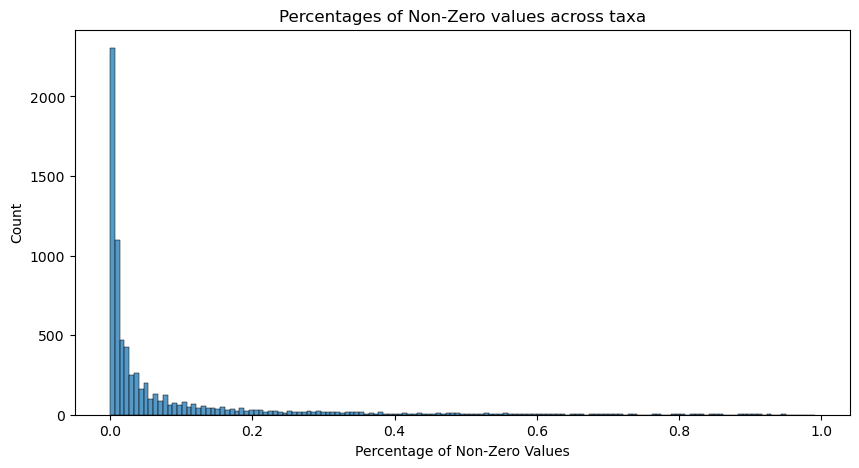

In [17]:
non_zero_value_counts = pd.Series([len(df[col][df[col] != 0]) for col in df.columns])
non_zero_value_pcts = non_zero_value_counts / len(df)

plt.figure(figsize=(10,5))
sns.histplot(non_zero_value_pcts)
plt.title("Percentages of Non-Zero values across taxa")
plt.xlabel("Percentage of Non-Zero Values")
plt.show()

In [18]:
non_zero_value_counts.describe()

count   7244.000000
mean      38.409856
std       71.884313
min        0.000000
25%        3.000000
50%        9.000000
75%       37.000000
max      516.000000
dtype: float64

### Preprocessing

Here is how an example taxa with id 302746 looks like before preprocessing

In [7]:
zero_values_percentage_cutoff = 0.5 # at least 50% of taxa must be non-zero values
smoothing_window_size = 5
df = preprocess(zero_values_percentage_cutoff=zero_values_percentage_cutoff, smoothing_window_size=smoothing_window_size)

2023-10-09 19:46:16.903531: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 19:46:16.903574: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 19:46:16.918630: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 19:46:16.931900: I tensorflow/core/platform/cpu_featu

In [8]:
example_taxa_idx = 302746
example_taxa_sequence_raw = df[example_taxa_idx]

In [9]:
example_taxa_sequence_preprocessed = df[example_taxa_idx]
df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
E000823.1.8,0.000000,0.000221,0.195402,0.002871,0.000000,0.252560,0.009901,0.145455,0.000000,0.087963,...,0.000000,0.237179,0.000433,0.102041,0.000000,0.042448,0.507874,0.063005,0.010525,0.043189
E000823.2.6,0.052888,0.000273,0.137931,0.012440,0.000000,0.204778,0.007921,0.109091,0.000000,0.120370,...,0.000000,0.173077,0.000939,0.163265,0.000067,0.037373,0.437008,0.056729,0.010298,0.019934
E000823.4.0,0.052888,0.000256,0.160920,0.013397,0.000000,0.443686,0.019802,0.072727,0.000000,0.074074,...,0.000000,0.179487,0.000987,0.183673,0.000067,0.053983,0.389764,0.069040,0.032819,0.013289
E000823.5.0,0.052888,0.000204,0.103448,0.053589,0.000000,0.375427,0.019802,0.054545,0.000000,0.064815,...,0.000000,0.166667,0.003901,0.183673,0.000089,0.048139,0.338583,0.052505,0.030623,0.000000
E000823.5.7,0.052888,0.000204,0.195402,0.053589,0.046985,0.382253,0.021782,0.054545,0.112668,0.078704,...,0.000000,0.147436,0.080911,0.122449,0.053025,0.044909,0.287402,0.054919,0.083269,0.013289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.22.5,0.054103,0.115345,0.172414,0.001435,0.058205,0.044369,0.033663,0.418182,0.361913,0.402778,...,0.339315,0.115385,0.000024,0.428571,0.045208,0.085205,0.177165,0.131201,0.328075,0.289037
E014086.23.4,0.084802,0.145123,0.183908,0.006699,0.062412,0.088737,0.035644,0.545455,0.462215,0.532407,...,0.428222,0.115385,0.000747,0.489796,0.061491,0.110889,0.212598,0.174412,0.407474,0.209302
E014086.24.5,0.094833,0.161664,0.379310,0.009091,0.105189,0.143345,0.067327,0.563636,0.874141,0.800926,...,0.644372,0.205128,0.000747,0.489796,0.084206,0.133959,0.283465,0.297284,0.596487,0.325581
E014086.26.4,0.059574,0.153453,0.597701,0.009091,0.183029,0.334471,0.071287,0.709091,0.932949,0.828704,...,0.712072,0.243590,0.000747,0.408163,0.071408,0.196555,0.334646,0.417139,0.741297,0.365449


#### Here is what our example taxa sequence 302746 looks like after preprocessing

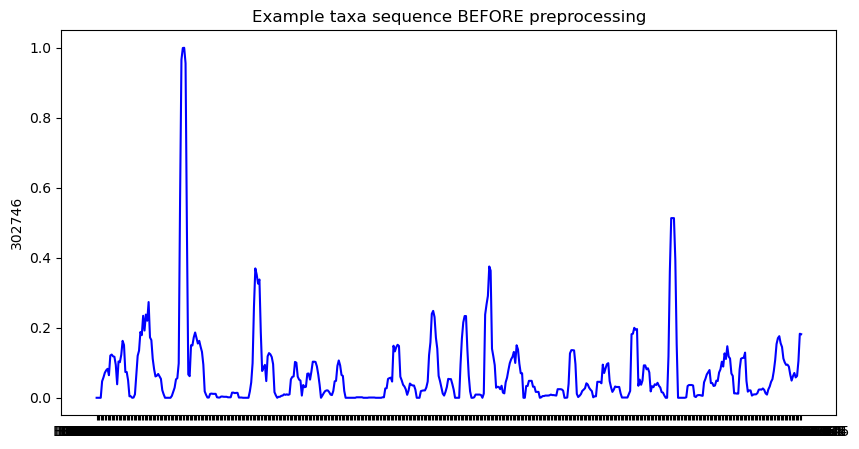

In [10]:
plot_a_taxa_sequence(sequence=example_taxa_sequence_raw, color="blue", title="Example taxa sequence BEFORE preprocessing")

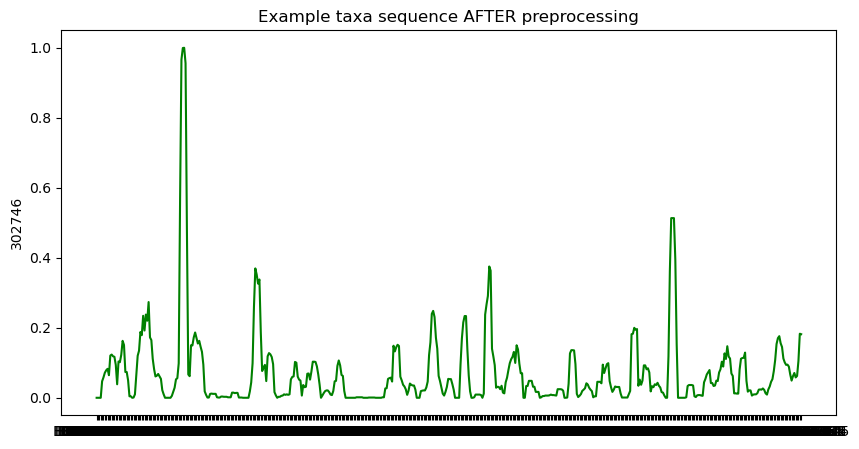

In [11]:
plot_a_taxa_sequence(sequence=example_taxa_sequence_preprocessed, color="green", title="Example taxa sequence AFTER preprocessing")

### Features and Targets

Now I prepare feature sequences and target sequences. For a detailed description of how this happens please read the description to function cut_to_sequences(). You will find it in functions.py

In [12]:
seq_length = 50
cutoff = 411

X_sequences, y_targets = cut_to_sequences(feats_df=df, seq_length=seq_length)

X_sequences_train = X_sequences[:cutoff]
y_targets_train = y_targets[:cutoff]

X_sequences_test = X_sequences[cutoff:]
y_targets_test = y_targets[cutoff:]

print(f"Length of data: {len(df)}")
print(f"Total sequences: {len(X_sequences)}")
print(f"Train sequences: {len(X_sequences_train)}")
print(f"Test sequences: {len(X_sequences_test)}")

Length of data: 516
Total sequences: 466
Train sequences: 411
Test sequences: 55


### The Model

In [13]:
reg = 1e-12
loss=mae_ignore_zeros(false_positives_penalty_factor=0.1)

n_feats = len(df.columns)

model = Sequential()
model.add(keras.Input(shape=(seq_length, n_feats)))
model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
model.add(keras.layers.Dense(2048, activation="tanh", kernel_regularizer=l1_l2(reg)))
model.add(keras.layers.Dense(n_feats, activation="relu", kernel_regularizer=l1_l2(reg)))

model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])

model.summary()

2023-10-09 19:46:23.800083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-09 19:46:23.817183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-09 19:46:23.817442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024)              5025792   
                                                                 
 dense (Dense)               (None, 2048)              2099200   
                                                                 
 dense_1 (Dense)             (None, 202)               413898    
                                                                 
Total params: 7538890 (28.76 MB)
Trainable params: 7538890 (28.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training and Validation

In [14]:
model.fit(x=X_sequences_train, y=y_targets_train, validation_split=0.05, epochs=10)

Epoch 1/10


2023-10-09 19:46:26.114058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-09 19:46:26.167503: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fef6402d9d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-09 19:46:26.167536: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-10-09 19:46:26.174952: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-09 19:46:26.191467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-09 19:46:26.299082: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

13/13 [==============================] - 3s 68ms/step - loss: 27.0994 - mae: 0.1097 - mape: 3784060.5000 - val_loss: 21.8954 - val_mae: 0.0910 - val_mape: 1128983.7500
Epoch 2/10
13/13 [==============================] - 1s 54ms/step - loss: 19.6397 - mae: 0.0830 - mape: 2011889.8750 - val_loss: 17.5525 - val_mae: 0.0843 - val_mape: 1016200.9375
Epoch 3/10
13/13 [==============================] - 1s 56ms/step - loss: 15.5040 - mae: 0.0723 - mape: 1188051.8750 - val_loss: 14.8707 - val_mae: 0.0801 - val_mape: 841623.2500
Epoch 4/10
13/13 [==============================] - 1s 53ms/step - loss: 12.9783 - mae: 0.0655 - mape: 1003127.8125 - val_loss: 13.3760 - val_mae: 0.0780 - val_mape: 1022555.8125
Epoch 5/10
13/13 [==============================] - 1s 56ms/step - loss: 11.3583 - mae: 0.0610 - mape: 735549.5625 - val_loss: 13.7840 - val_mae: 0.0902 - val_mape: 1171306.8750
Epoch 6/10
13/13 [==============================] - 1s 61ms/step - loss: 10.0784 - mae: 0.0565 - mape: 710906.5000 - v

In [15]:
y_pred = model.predict(X_sequences_test)

2/2 [==============================] - 0s 8ms/step


In [16]:
y_test_df = pd.DataFrame(y_targets_test)
y_pred_df = pd.DataFrame(y_pred)

In [17]:
y_test_df

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,0.037386,0.013270,0.436782,0.017225,0.147265,0.109215,0.615842,0.254545,0.009343,0.046296,...,0.268352,0.153846,0.021143,0.163265,0.053025,0.587819,0.082677,0.266264,0.265606,0.302326
1,0.019149,0.012742,0.344828,0.014833,0.117812,0.054608,0.483168,0.254545,0.009343,0.046296,...,0.238989,0.083333,0.021143,0.163265,0.040316,0.453091,0.062992,0.202535,0.222715,0.235880
2,0.012158,0.014207,0.264368,0.014354,0.112202,0.058020,0.843564,0.254545,0.018137,0.101852,...,0.196574,0.070513,0.020396,0.142857,0.076992,0.786066,0.055118,0.393724,0.255036,0.481728
3,0.008207,0.010511,0.103448,0.008134,0.069425,0.040956,0.506931,0.072727,0.096455,0.074074,...,0.079119,0.032051,0.018687,0.061224,0.062362,0.582744,0.055118,0.300905,0.142139,0.385382
4,0.008207,0.004054,0.057471,0.006699,0.062412,0.037543,0.435644,0.018182,0.089860,0.078704,...,0.061990,0.032051,0.050690,0.040816,0.058386,0.470624,0.059055,0.257333,0.089946,0.338870
5,0.001520,0.004940,0.137931,0.003349,0.012623,0.098976,0.475248,0.000000,0.089035,0.078704,...,0.013051,0.121795,0.128928,0.040816,0.056085,0.616887,0.192913,0.305854,0.089652,0.335548
6,0.001520,0.007478,0.137931,0.006220,0.012623,0.109215,0.487129,0.000000,0.092883,0.078704,...,0.013051,0.134615,0.147687,0.040816,0.056085,0.653491,0.212598,0.324321,0.100833,0.335548
7,0.000608,0.006712,0.091954,0.008612,0.011921,0.112628,0.077228,0.000000,0.244573,0.013889,...,0.004894,0.179487,0.172972,0.020408,0.004221,0.257767,0.204724,0.107423,0.037753,0.049834
8,0.000000,0.006184,0.114943,0.008134,0.011921,0.129693,0.073267,0.000000,0.165155,0.004630,...,0.000816,0.185897,0.173140,0.000000,0.000424,0.246386,0.200787,0.107906,0.070708,0.003322
9,0.000000,0.006490,0.229885,0.016268,0.080645,0.133106,0.089109,0.000000,0.169827,0.000000,...,0.267537,0.160256,0.132155,0.000000,0.009225,0.261150,0.200787,0.126735,0.127246,0.000000


In [18]:
y_pred_df

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,0.038666,0.000000,0.149483,0.000288,0.084071,0.171039,0.235021,0.178967,0.121016,0.221058,...,0.301133,0.074221,0.000000,0.141014,0.000000,0.296152,0.082584,0.223154,0.219907,0.144309
1,0.057267,0.000000,0.148760,0.013929,0.098630,0.157431,0.219631,0.163707,0.105053,0.218169,...,0.294054,0.071263,0.000000,0.135185,0.000000,0.282002,0.077830,0.212799,0.224616,0.129978
2,0.059536,0.000000,0.133134,0.023235,0.092484,0.131285,0.181394,0.140036,0.083205,0.192359,...,0.251297,0.062000,0.000000,0.126863,0.000000,0.238947,0.068890,0.178807,0.204942,0.116122
3,0.068305,0.000000,0.142516,0.015884,0.093255,0.127120,0.232582,0.146785,0.089146,0.211845,...,0.277417,0.060254,0.000000,0.134657,0.000000,0.294767,0.058124,0.215967,0.238992,0.118832
4,0.053016,0.000000,0.122982,0.017522,0.056987,0.101253,0.204411,0.116364,0.071282,0.171051,...,0.216012,0.049112,0.000000,0.122942,0.000000,0.257991,0.049535,0.187327,0.205796,0.109047
5,0.049212,0.000000,0.108775,0.016733,0.048014,0.089935,0.172391,0.100023,0.063611,0.145639,...,0.194030,0.038195,0.000000,0.112952,0.000000,0.220686,0.041842,0.161807,0.170867,0.102762
6,0.035583,0.000000,0.110459,0.009092,0.022651,0.098887,0.158102,0.093114,0.066566,0.128702,...,0.160468,0.057056,0.000000,0.119476,0.000000,0.209874,0.065679,0.152841,0.153291,0.085394
7,0.029056,0.000000,0.114939,0.005700,0.007122,0.109142,0.147926,0.090639,0.069726,0.118987,...,0.139685,0.076299,0.000000,0.127908,0.000000,0.204963,0.089150,0.146282,0.139370,0.067703
8,0.027199,0.000000,0.112240,0.016018,0.000000,0.115744,0.083444,0.072248,0.049897,0.088008,...,0.084529,0.095879,0.000000,0.122917,0.000000,0.143758,0.121299,0.103765,0.096408,0.048427
9,0.031539,0.000000,0.116321,0.022840,0.000000,0.122304,0.047060,0.057529,0.036618,0.067830,...,0.057125,0.110448,0.000000,0.117149,0.000000,0.112037,0.142674,0.081370,0.072204,0.028038


Usually at least some of the taxa are not predictable by a model. Then it returns zeros for their entire sequence

In [19]:
non_predicted_cols = [col for col in y_pred_df.columns if all(y_pred_df[col] == 0.0)]
n_non_predicted_cols = len(non_predicted_cols)

print(f"Total taxa not predicted: {n_non_predicted_cols}, {(n_non_predicted_cols/len(y_test_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 15, 7.425742574257425% of all taxa


The next section allows to examine individual true and predicted sequences

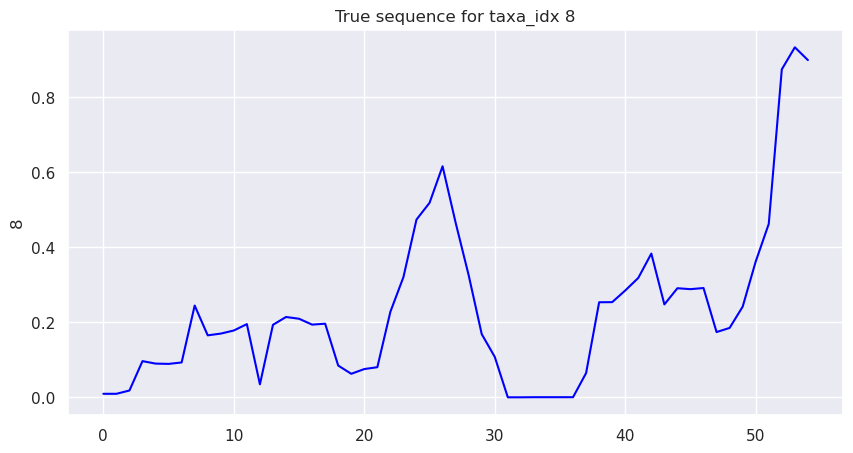

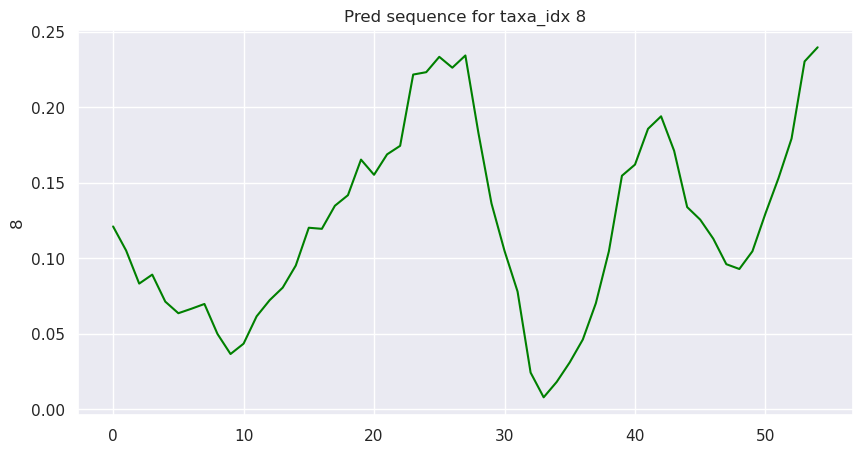

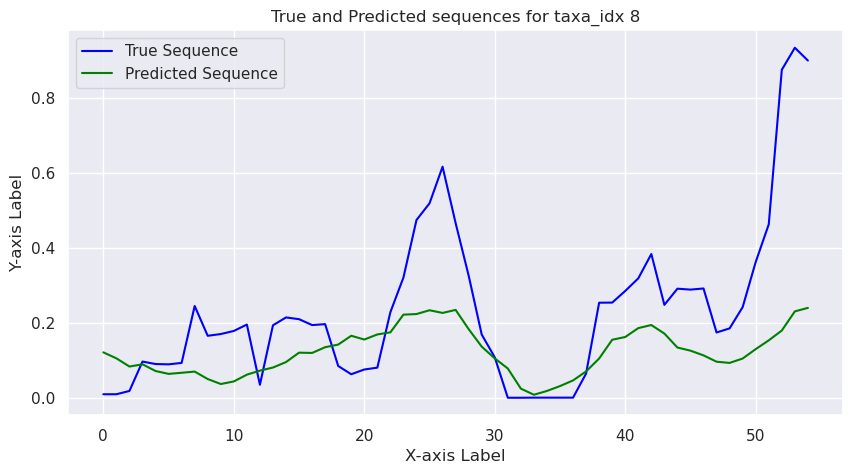

In [20]:
target_taxa = 8
true_sequence = y_test_df[target_taxa]
pred_sequence = y_pred_df[target_taxa]

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

Now I look at the performance across different sequences

In [21]:
errors_df = calculate_percentage_errors(y_pred_df, y_test_df)
errors_df.describe()


,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,91351201.789850,2249847427.535937,0.625078,63853850.174681,119597101.037882,0.520717,2160216.870395,0.643023,1.145725,0.497260,...,0.659686,0.635496,271284615.358593,0.433322,496506457.981419,0.591429,0.547050,0.570894,0.642063,0.978245
std,223597664.883446,2965623042.675204,0.480868,90685987.223177,293105681.461753,0.334893,11222886.533912,0.524430,0.882175,0.381996,...,0.725847,0.472286,441601969.413143,0.328806,437601340.539997,0.510183,0.603265,0.465692,0.430697,0.847415
min,0.033107,40543762.873899,0.012464,0.064882,0.034323,0.005599,0.000000,0.032411,0.027204,0.001230,...,0.012900,0.006633,0.675124,0.000466,0.665387,0.000000,0.001125,0.009119,0.008463,0.005104
25%,0.968681,160386356.074687,0.224340,0.590572,0.602995,0.195438,0.278171,0.272113,0.522599,0.201669,...,0.184911,0.246827,2167264.642242,0.158353,101069887.641214,0.227859,0.179046,0.190105,0.282059,0.313764
50%,1.000000,1148512812.167328,0.580362,33492822.519330,1.769203,0.556163,0.682913,0.554881,0.975580,0.429065,...,0.415299,0.611174,35157848.640810,0.360288,403609473.961708,0.450657,0.335318,0.437901,0.571667,0.748095
75%,1519759.124680,2916510471.775547,0.981020,93301434.160991,23.693787,0.833274,1.354087,0.929952,1.354135,0.756700,...,0.917041,0.969433,402750012.683250,0.651374,784771381.718019,0.870335,0.718466,0.981412,0.997256,1.290971
max,948328254.815663,9999999866.485682,2.005522,368421047.712630,1115006997.735781,1.000000,79207919.734540,3.208873,3.879245,1.549078,...,3.683340,2.188775,1731403641.968648,1.271693,1445355232.986282,2.289705,3.610529,2.109640,1.767213,3.148459


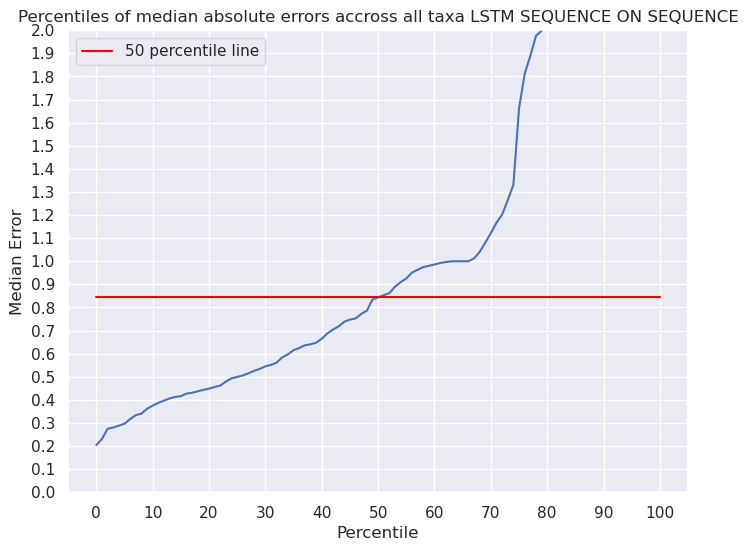

In [22]:
percentile_graph(errors_df, "accross all taxa LSTM SEQUENCE ON SEQUENCE", y_top_lim=2)

Same graph, but only for those taxa that are not all predicted zero

In [23]:
only_predicted_errors = errors_df[errors_df.columns[~(errors_df.columns.isin(non_predicted_cols))]]
only_predicted_errors.describe()

,0,2,3,4,5,6,7,8,9,10,...,192,193,194,195,196,197,198,199,200,201
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,91351201.789850,0.625078,63853850.174681,119597101.037882,0.520717,2160216.870395,0.643023,1.145725,0.497260,7301936.122324,...,0.659686,0.635496,271284615.358593,0.433322,496506457.981419,0.591429,0.547050,0.570894,0.642063,0.978245
std,223597664.883446,0.480868,90685987.223177,293105681.461753,0.334893,11222886.533912,0.524430,0.882175,0.381996,27964281.386860,...,0.725847,0.472286,441601969.413143,0.328806,437601340.539997,0.510183,0.603265,0.465692,0.430697,0.847415
min,0.033107,0.012464,0.064882,0.034323,0.005599,0.000000,0.032411,0.027204,0.001230,0.000000,...,0.012900,0.006633,0.675124,0.000466,0.665387,0.000000,0.001125,0.009119,0.008463,0.005104
25%,0.968681,0.224340,0.590572,0.602995,0.195438,0.278171,0.272113,0.522599,0.201669,0.305340,...,0.184911,0.246827,2167264.642242,0.158353,101069887.641214,0.227859,0.179046,0.190105,0.282059,0.313764
50%,1.000000,0.580362,33492822.519330,1.769203,0.556163,0.682913,0.554881,0.975580,0.429065,0.846568,...,0.415299,0.611174,35157848.640810,0.360288,403609473.961708,0.450657,0.335318,0.437901,0.571667,0.748095
75%,1519759.124680,0.981020,93301434.160991,23.693787,0.833274,1.354087,0.929952,1.354135,0.756700,1.567555,...,0.917041,0.969433,402750012.683250,0.651374,784771381.718019,0.870335,0.718466,0.981412,0.997256,1.290971
max,948328254.815663,2.005522,368421047.712630,1115006997.735781,1.000000,79207919.734540,3.208873,3.879245,1.549078,120481926.102237,...,3.683340,2.188775,1731403641.968648,1.271693,1445355232.986282,2.289705,3.610529,2.109640,1.767213,3.148459


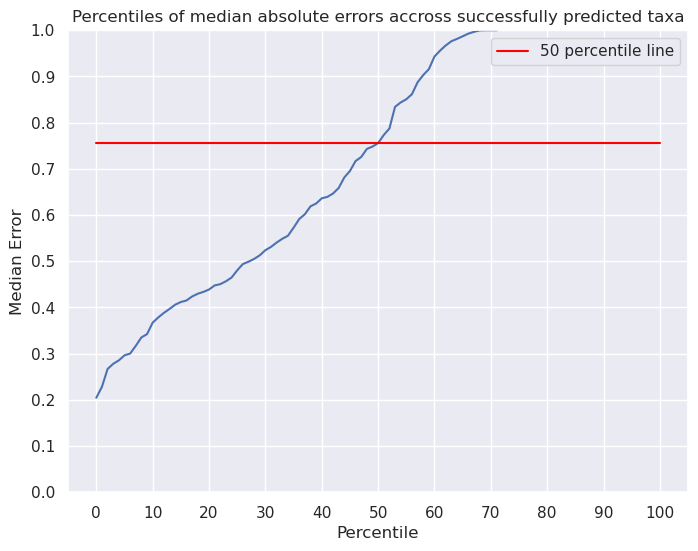

In [24]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa", y_top_lim=1)